# Спрос на рынке жилья (за счет собственных средств)

В блоке оцениваются три модели:
  1. **Модель 1. Площадь строящегося жилья, приобретенного за счет собственных средств** (п. 1 блокнота)
  2. **Модель 2. Площадь готового жилья, приобретенного за счет собственных средств** (п. 2 блокнота)
  3. **Модель 3. Количество семей, улучшивших жилищные условия** (п. 4 блокнота)

**Окончательный результат блока расчитывается рекурсивно по формуле в п. 4 этого блокнота** с использованием результатов оценки всех моделей 

Связи переменных данного блока
  - красный цвет: переменные из базы данных
  - зеленый цвет: общие переменные для двух моделей
  - синий цвет: переменные модели 1
  - желтый цвет: переменные модели 2

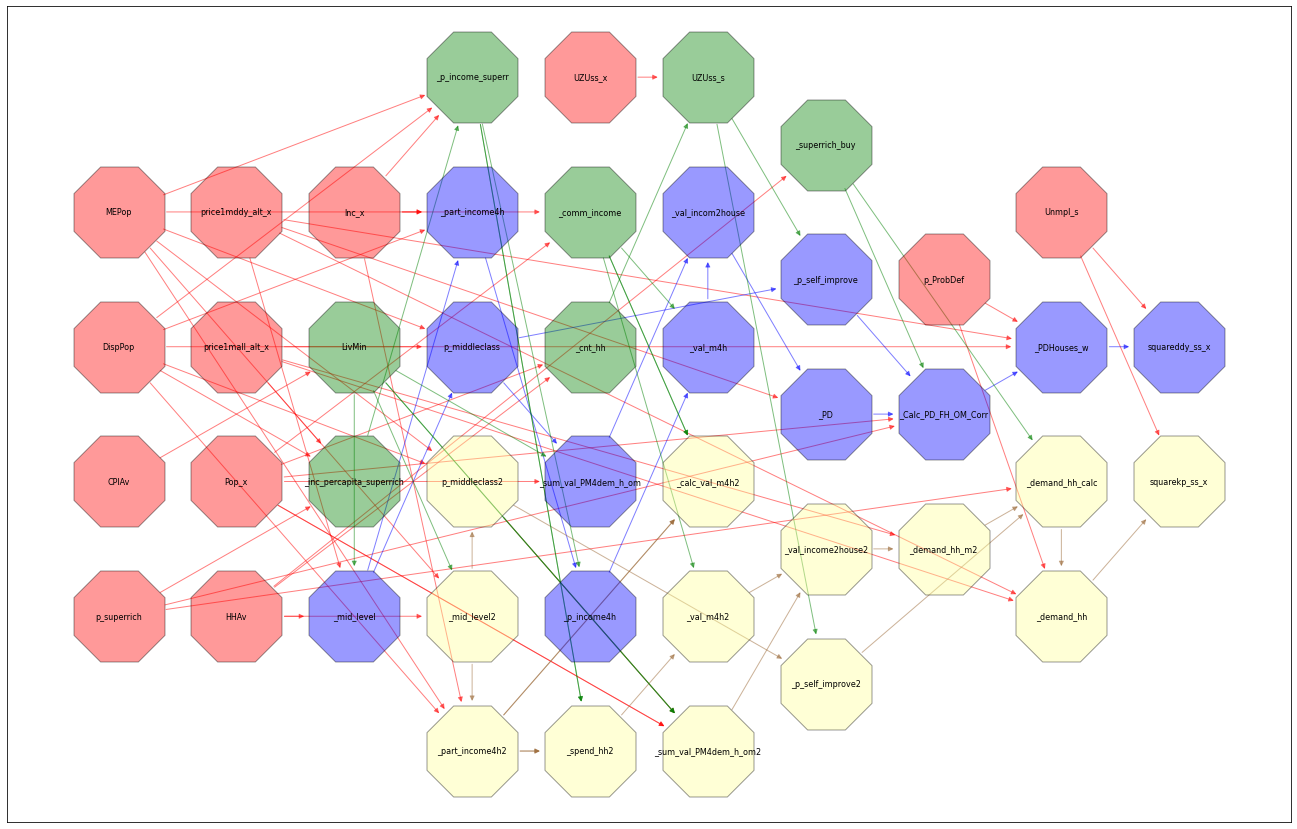

<details>
<table align=left border="1">
<tr><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Загружаем из-вне</td><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Загружаем и считаем</td><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Считаем</td></tr>
<tr><td style="vertical-align:top">
    <table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">CPIAv</td><td style="text-align:left">ИПЦ, в среднем за год</td></tr>
    <tr><td style="text-align:left;font-weight:bold">Pop_x</td><td style="text-align:left">Численность населения (среднегодовая)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">HHAv</td><td style="text-align:left">Средний размер домохозяйства</td></tr>
    <tr><td style="text-align:left;font-weight:bold">Unmpl_s</td><td style="text-align:left">Уровень безработицы</td></tr>
    <tr><td style="text-align:left;font-weight:bold">Inc_x</td><td style="text-align:left">Среднедушевые денежные доходы населения (в текущих ценах)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_ProbDef</td><td style="text-align:left">Вероятность дефолта проекта и/или застройщика</td></tr>
    <tr><td style="text-align:left;font-weight:bold">price1mddy_alt_x</td><td style="text-align:left">Средняя цена 1 кв. м по ДДУ</td></tr>
    <tr><td style="text-align:left;font-weight:bold">price1mall_alt_x</td><td style="text-align:left">Средняя цена 1 кв. м на рынке готового жилья</td></tr>
    <tr><td style="text-align:left;font-weight:bold">MEPop</td><td style="text-align:left">Параметр $\mu$ нормального распределения и распределения Колмакова</td></tr>
    <tr><td style="text-align:left;font-weight:bold">DispPop</td><td style="text-align:left">Параметр $\sigma$ нормального распределения и распределения Колмакова</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_superrich</td><td style="text-align:left">Доля сверхбогатого населения</td></tr>
    </table>
</td><td style="vertical-align:top">
    <table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">squareddy_ss_x</td><td style="text-align:left">Модель 1 Площадь строящегося жилья, приобретенного за счет собственных средств - факт</td></tr>
    <tr><td style="text-align:left;font-weight:bold">squarekp_ss_x</td><td style="text-align:left">Модель 2 Площадь готового жилья, приобретенного за счет собственных средств - факт</td></tr>
    <tr><td style="text-align:left;font-weight:bold">LivMin</td><td style="text-align:left">Прожиточный минимум</td></tr>
    <tr><td style="text-align:left;font-weight:bold">UZUss_x</td><td style="text-align:left">Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет</td></tr>
            <tr><td style="text-align:left;font-weight:bold">sdelkiddy_ss_x</td><td style="text-align:left">Количество сделок с ДДУ/Эскроу</td></tr>
    <tr><td style="text-align:left;font-weight:bold">sdelkikp_ss_x</td><td style="text-align:left">Количество сделок по договорам купли-продажи</td></tr>
    </table>
</td>
    <td style="vertical-align:top">
<table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">_PDHouses_w</td><td style="text-align:left">Потенциальный спрос на жилье</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_self_improve</td><td style="text-align:left">Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, %</td></tr>
    <tr><td style="text-align:left;font-weight:bold">UZUss_s</td><td style="text-align:left">Доля семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_cnt_hh</td><td style="text-align:left">Число домохозяйств</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_Calc_PD_FH_OM_Corr</td><td style="text-align:left">Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_PD</td><td style="text-align:left">Потенциальный спрос</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_val_incom2house</td><td style="text-align:left">Общий объем денежных доходов, которые могут потратить на жилье</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_comm_income</td><td style="text-align:left">Общий объем денежных доходов населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_val_m4h</td><td style="text-align:left">Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_sum_val_PM4dem_h_om</td><td style="text-align:left">Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_mid_level</td><td style="text-align:left">Порог</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_part_income4h</td><td style="text-align:left">Доля денежных доходов, которые могут потратить на жилье (включая ПМ)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_middleclass</td><td style="text-align:left">Доля населения с доходами выше порога</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_superrich_buy</td><td style="text-align:left">Типовая покупка жилья сверхбогатым населением в год на чел</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_inc_percapita_superrich</td><td style="text-align:left">Среднедушевые доходы сверхбогатого населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_income_superr</td><td style="text-align:left">Доля доходов сверхбогатого населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_income4h</td><td style="text-align:left">Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_cnt_deal_om</td><td style="text-align:left">Количество сделок по покупке жилья за счет собственных средств на первичном и вторичном рынках</td></tr>
    <tr><td style="text-align:left;font-weight:bold">_p_self_improve2</td><td style="text-align:left">Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, %</td></tr>
<tr><td style="text-align:left;font-weight:bold">_demand_hh_calc</td><td style="text-align:left">Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий</td></tr>
<tr><td style="text-align:left;font-weight:bold">_demand_hh_m2</td><td style="text-align:left">Потенциальный спрос (количество кв. м)</td></tr>
<tr><td style="text-align:left;font-weight:bold">_val_incom2house2</td><td style="text-align:left">Общий объем денежных доходов, которые могут потратить на жилье</td></tr>
<tr><td style="text-align:left;font-weight:bold">_val_m4h2</td><td style="text-align:left">Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ)</td></tr>
<tr><td style="text-align:left;font-weight:bold">_sum_val_PM4dem_h_om2</td><td style="text-align:left">Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств</td></tr>
<tr><td style="text-align:left;font-weight:bold">_calc_val_m4h2</td><td style="text-align:left">Расчет общего объема денежных доходов, которые могут потратить на готовое жилье (включая ПМ)</td></tr>
<tr><td style="text-align:left;font-weight:bold">_mid_level2</td><td style="text-align:left">Порог</td></tr>
<tr><td style="text-align:left;font-weight:bold">_part_income4h2</td><td style="text-align:left">Доля денежных доходов, которые могут потратить на жилье (включая ПМ)</td></tr>
<tr><td style="text-align:left;font-weight:bold">_p_middle_class2</td><td style="text-align:left">Доля населения с доходами выше порога</td></tr>
<tr><td style="text-align:left;font-weight:bold">_spend_hh2</td><td style="text-align:left">Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения</td></tr>
    </table>
    </td></tr>
</table>
</details>

In [123]:
from IPython.display import Markdown as md
import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm

%run ../COMMON/common.ipynb # загрузка общих функций и констант, все, что оттуда, должно иметь префикс common.

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strYearDBPath)) # connection к рабочей базе данных
conWorkEx = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strExYearDBPath)) # connection к к рабочей базе данных экзогенных переменных
conWorkExH=sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strExParamDBPath)) # connection к рабочей базе данных экзогенных параметров
conWorkSvod=sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=common.strSvodDBPath)) # connection к рабочей базе данных СВОД


iFirstFactYear=2008
iLastFactYear=2019

iFirstForecastYear=iLastFactYear+1
iLastForecastYear=2030

In [124]:
class DemandOM:
    pdfWork=None
    
    lstYearCodes=['squareddy_ss_x', 'CPIAv', 'Pop_x', 'HHAv', 'Unmpl_s', 'DispInc_rI', 'Inc_x', 'p_ProbDef', 
              'UZUss_x', 'MEPop', 'DispPop', 'LivMin', 'p_superrich', 'sdelkiddy_ss_x', 'sdelkikp_ss_x', 
              'squarekp_ss_x', 'DispInc_I','oldpravaddy_x','longarenda','izavarijnogo',
              'kapremont','partinZSK','Badzhilfond_x','sdelkikp_x'] # список экзогенных и фактических данных
 

    lstSvod=['price1mddy_alt_x', 'price1mall_alt_x', 'AvSqDdy', 'AvSqVtor','VvodyIZDunits','VvodyMKD',
         'VvodyMKD_inst','VvodyMKD_gov','VvodyIZD','VvodyMKDunits','sdelkikp_x','sdelkiddy_x'] # результаты из блока "Цены и себестоимость"
    
    def __init__(self):
        assert False, 'you can\'t create variables of DemandOM class!'
    
    def MakeWorkFrame():
        ''' Загрузка исходных данных
            Исходные данные:
                Фактические значения - из базы данных year.sqlite3;
                Экзогенные - из базы данных exog_year.sqlite3
                Задаваемые вручную - из базы данных exog_param.sqlite3
                Результаты других моделей - из базы данных svod.sqlite3. 
        '''
        
        pdfAct=(pd.read_sql(common.make_select_year_string(DemandOM.lstYearCodes), con=conWork)
        .pipe(common.make_frame)
        .pipe(common.scale, list_fields=['Inc_x',], multiplier=1e3)
        .pipe(common.scale, list_fields=['sdelkiddy_ss_x',], multiplier=1e-6))
        pdfExog=pd.read_sql(common.make_select_year_string(DemandOM.lstYearCodes), con=conWorkEx).pipe(common.make_frame)
        PdfExogHandle=pd.read_sql(common.make_select_year_string(DemandOM.lstYearCodes), con=conWorkExH).pipe(common.make_frame)

        pdfSvod=(pd.read_sql(common.make_select_year_string(DemandOM.lstSvod), con=conWorkSvod)
              .pipe(common.make_frame)
             .pipe(common.scale, list_fields=['price1mddy_alt_x', 'price1mall_alt_x'], multiplier=1e3))

        DemandOM.pdfWork=pdfAct.combine_first(pdfExog).combine_first(PdfExogHandle).combine_first(pdfSvod).pipe(common.scale, list_fields=['Unmpl_s',], multiplier=100)
        DemandOM.pdfWork['_cnt_deal_om'] =  DemandOM.pdfWork['sdelkiddy_ss_x'] +  DemandOM.pdfWork['sdelkikp_ss_x']
        return DemandOM.pdfWork
    
# a=DemandOM()


In [125]:
pdfAct=(pd.read_sql(common.make_select_year_string(DemandOM.lstYearCodes), con=conWork))#.pipe(common.make_frame))
pdfAct[pdfAct[['date', 'code2']].duplicated(keep=False)]

,date,value,code2


In [126]:
DemandOM.MakeWorkFrame()
# pdfWork#.sample(5).sort_index()

,AvSqDdy,AvSqVtor,Badzhilfond_x,CPIAv,DispInc_I,DispPop,HHAv,Inc_x,LivMin,MEPop,...,partinZSK,price1mall_alt_x,price1mddy_alt_x,sdelkiddy_ss_x,sdelkiddy_x,sdelkikp_ss_x,sdelkikp_x,squareddy_ss_x,squarekp_ss_x,_cnt_deal_om
date,,,,,,,,,,,,,,,,,,,,,
2004,NaN,NaN,NaN,1.108812,1.104000,NaN,2.677054,6410.300000,2376.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,65.703978,NaN,NaN,1.127055,1.124000,0.756100,2.661470,8088.300000,3018.0,8.711611,...,NaN,21048.567265,18491.692819,0.143936,NaN,1.334440,1.443503,NaN,NaN,1.478376
2006,65.107090,NaN,NaN,1.096830,1.135000,0.769907,2.645886,10154.800000,3422.0,8.928732,...,NaN,28597.165335,24937.896936,0.152925,NaN,1.417784,1.564560,NaN,NaN,1.570709
2007,64.216907,NaN,NaN,1.089881,1.121000,0.785663,2.630302,12540.200000,3847.0,9.129498,...,NaN,37938.493305,32765.902784,0.162476,NaN,1.506332,1.703862,NaN,NaN,1.668809
2008,63.243902,NaN,2.333110,1.141048,1.024000,0.782878,2.614717,14863.600000,4593.0,9.301331,...,NaN,44576.706072,37788.915681,0.507313,NaN,1.265722,1.550739,NaN,65.564414,1.773035
2009,61.675214,50.877922,2.910700,1.116977,1.030000,0.783533,2.599133,16895.000000,5153.0,9.427587,...,NaN,42565.501231,36473.861415,0.282607,NaN,1.182876,1.299313,NaN,60.182264,1.465483
2010,60.086697,50.985166,2.584900,1.068508,1.059000,0.782280,2.583549,18958.400000,5688.0,9.546797,...,NaN,41870.584649,35853.805771,0.117507,0.145883,1.655528,1.925781,7.060626,84.407359,1.773035
2011,58.132834,51.084428,2.387000,1.084634,1.005000,0.775441,2.544156,20780.000000,6369.0,9.644999,...,NaN,44815.617500,37897.472700,0.161405,0.233760,1.983726,2.427822,9.382939,101.337510,2.145131
2012,56.425400,51.185577,2.043990,1.050667,1.046000,0.781314,2.504763,23221.100000,6510.0,9.747765,...,NaN,50629.950501,41865.338092,0.204777,0.331445,2.074330,2.623857,11.554604,106.175779,2.279107


<H1 style="color:navy">Модель 1. Площадь строящегося жилья, приобретенного за счет собственных средств</H1>

## 1. Потенциальный спрос на жилье - _PDHouses_w   

В расчете используются следующие переменные (формулы переменных приведены ниже):
  - Потенциальный спрос - **\_PD** (блок 1.1)
  - Типовая покупка жилья сверхбогатым населением в год на чел - **\_superrich\_buy** (блок 1.2) 
  - Доля семей, фактически улучшивших жилищные условия за скользящие 7 лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % - **\_p\_self\_improve** (блок 1.3)
  - Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий - **\_Calc\_PD\_FH\_OM\_Corr** (блок 1.4)
  -  Потенциальный спрос на жилье - **_PDHouses_w** (блок 1.4)

### 1.1 Расчет  Потенциального спроса (\_PD)

Для расчета Потенциального спроса (\_PD) необходимо расчитать следующие переменные:
  - \_comm\_income - Общий объем денежных доходов населения
  - \_part\_income4h - Общего объема денежных доходов, которые могут потратить на жилье (включая ПМ)
  - p\_middleclass - Доля населения с доходами выше порога
  - LivMin - Прожиточный минимум
  - \_val\_m4h - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ)
  - \_sum\_val\_PM4dem\_h\_om - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств

а так же переменных, используемых в расчете переменных выше
  - \_p\_income\_superr - Доля доходов сверхбогатого населения
  - \_mid\_level - Порог
  - \_p\_income4h - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения
  - \_inc\_percapita\_superrich - Среднедушевые доходы сверхбогатого населения

#### 1.1.1 Доля доходов сверхбогатого населения (переменная \_p\_income\_superr)

Для расчета используются следующие входные данные:
  - Среднедушевые денежные доходы населения (в текущих ценах) - *Inc\_x*, загружаются из базы данных
  - Параметр $\mu$ (матожидание) распределения **доходов населения** по уровню среднедушевого среднемесячного денежного дохода в денежном выражении - *MEPop*. ОДновременно это параметр $\mu$ для нормального распределения **населения** по уровню денежных доходов, полученного из логнормального распределения населения по уровню среднедушевых доходов - **данные из ДОМ.РФ**
  - Параметр $\sigma$ (среднеквадратичное отклонение) распределения **доходов населения** по уровню среднедушевого среднемесячного денежного дохода в денежном выражении - *DispPop*. ОДновременно это параметр $\sigma$ для нормального распределения **населения** по уровню денежных доходов, полученного из логнормального распределения населения по уровню среднедушевых доходов - **данные из ДОМ.РФ**
  - Доля сверхбогатого населения - *p_superrich*, загружается из базы данных (наша гипотеза?)
  
**Алгоритм расчета:**
  1. Определяем *Среднедушевые доходы сверхбогатого населения* - *\_inc\_percapita\_superrich*   
  
  $\_inc\_percapita\_superrich=\large{e^{{\mathcal{N}(MEPop,\,DispPop^{2}).ppf(1-p\_superrich)}}} $    
  
  
  где ppf - Percent point function (inverse of cdf — percentiles) **нормального распределения** $\mathcal{N}(MEPop,\,DispPop^{2})   $
  
  2. Полученную величину \_inc\_percapita\_superrich используем в качестве X для нахождения доли *доходов сверхбогатого населения (переменная _p_income_superr)* по распределению *доходов населения по уровню среднедушевого среднемесячного денежного дохода в денежном выражении* - [И.Б. Колмаков "Методология расчета и анализа интегральных оценок показателей поляризации денежных доходов населения"](https://voprstat.elpub.ru/jour/article/view/189?locale=ru_RU). 
  pdf (Probability density function) этого распределения имеет вид:
  
   $kolmakov.pdf(x, \sigma, \mu) = \displaystyle\frac{1}{\sigma \sqrt{2\pi}}
                  \exp\left(-\frac{(\log(x)-\mu)^2}{2\sigma^2}\right)$
                  
   искомая величина  
   $ \_p\_income\_superr = 1-\displaystyle{\frac{kolmakov.cdf(x, \sigma, \mu)}{Inc\_x}}$
   
   где kolmakov.cdf - сumulative distribution function для распределения выше (интеграл от 0 до x по кривой распределения) с параметрами $\sigma = DispPop$ и $\mu = MEPop$ 

In [127]:
def _calc_superrich_perca_income(x):
    return 1-common.kolmakov.cdf(x['_inc_percapita_superrich'], sigma=x['DispPop'], mu=x['MEPop'])/x['Inc_x']

DemandOM.pdfWork['_inc_percapita_superrich']=np.exp(norm.ppf(1-DemandOM.pdfWork['p_superrich'], 
                                                              loc=DemandOM.pdfWork['MEPop'], 
                                                              scale=DemandOM.pdfWork['DispPop']))

DemandOM.pdfWork['_p_income_superr']=DemandOM.pdfWork[['_inc_percapita_superrich', 'DispPop', 
                                     'MEPop', 'Inc_x']].apply(_calc_superrich_perca_income, axis=1)

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_inc_percapita_superrich', 'DispPop', 'MEPop', 'Inc_x', '_p_income_superr']]

,_inc_percapita_superrich,DispPop,MEPop,Inc_x,_p_income_superr
date,,,,,
2015,109395.951680,0.765043,10.031523,30254.400000,0.092627
2016,110193.168853,0.763400,10.042158,30865.000000,0.101911
2017,112229.017148,0.759399,10.068682,31896.500000,0.109627
2018,119197.560879,0.765300,10.116803,33178.100000,0.098795
2019,126316.337878,0.764492,10.176471,35249.300000,0.100011
2020,126033.168298,0.764492,10.174226,35154.629192,0.099611


#### 1.1.2 Доля населения с доходами выше порога - p_middleclass, Порог - \_mid\_level и Прожиточный минимум - LivMin
<br>   
Расчет доли населения с доходами выше порога делаем аналогично расчету доли сверхбогатого населения 

&emsp;&emsp;&emsp;  $p\_middleclass=1-{\mathcal{N}(MEPop,\,DispPop^{2}).cdf(log(\_mid\_level)}) $    
  
&emsp;  где cdf - cumulative distribution function **нормального распределения** $\mathcal{N}(MEPop,\,DispPop^{2})   $

но величину порогового дохода - \_mid\_level (Х для нормального распределения населения по доходам, полученного из логнормального), определяем от:
  - LivMin - Прожиточного минимума (**загружаем из базы данных, расчитываем**)
  - HHAv - Среднего размера  домохозяйства (**из базы данных**)
  - price1mddy\_alt\_x - Средняя цена 1 кв. м по ДДУ (**из другого блока**)
  
  $\begin{equation*}
    LivMin =  
     \begin{cases}
       LivMin_y; \quad \text{при y < прогнозных годов} \\
       LivMin_{y-1} * CPIAv \quad \text{при y>= прогнозных годов }
     \end{cases}
\end{equation*}$

  где CPIAv - ИПЦ, в среднем за год (**из базы данных**)
  
  $\_mid\_level = LivMin + \left({\frac{\frac{\large\frac{54}{12}}{\large HHAv}}{\large 7}}\right) * price1mddy\_alt\_x $

In [128]:
idxnan = DemandOM.pdfWork['LivMin'].last_valid_index()
DemandOM.pdfWork.loc[idxnan:, 'LivMin']=DemandOM.pdfWork['LivMin'].combine_first(DemandOM.pdfWork['CPIAv']).loc[idxnan:].cumprod()

DemandOM.pdfWork['_mid_level']=DemandOM.pdfWork['LivMin'] + (54 / 12 / DemandOM.pdfWork['HHAv'] / 7) * DemandOM.pdfWork['price1mddy_alt_x']
DemandOM.pdfWork['p_middleclass']=1-norm.cdf(np.log(DemandOM.pdfWork['_mid_level']), 
                                              loc=DemandOM.pdfWork['MEPop'], 
                                              scale=DemandOM.pdfWork['DispPop'])

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['CPIAv', 'LivMin', 'price1mddy_alt_x', 'HHAv', '_mid_level', 'p_middleclass']]

,CPIAv,LivMin,price1mddy_alt_x,HHAv,_mid_level,p_middleclass
date,,,,,,
2015,1.155546,9701.000000,48153.946670,2.386583,22671.890766,0.501378
2016,1.070664,9828.000000,47585.730100,2.386583,22645.834255,0.507539
2017,1.036931,10088.000000,47804.624458,2.386583,22964.796293,0.514162
2018,1.028759,10287.000000,49884.125622,2.386583,23723.936931,0.522176
2019,1.044779,10890.000000,53625.435044,2.386583,25334.707201,0.519061
2020,1.033015,11249.529243,63272.175453,2.386583,28292.711227,0.460336


#### 1.1.3 Доля денежных доходов, которые могут потратить на жилье (включая ПМ) - \_part\_income4h	

&emsp;&emsp;&emsp; $ \_part\_income4h = 1-\displaystyle{\frac{kolmakov.cdf(\_mid\_level)}{Inc\_x}}$
   
   где 
   - kolmakov.cdf - сumulative distribution function для распределения доходов населения по уровню среднедушевого среднемесячного денежного дохода в денежном выражении (см. выше) с параметрами $\mu=MEPop$ и $\sigma = DispPop$
   - \_mid\_level - порог (считаем выше)
   - Inc\_x - Среднедушевые денежные доходы населения (в текущих ценах) (из базы данных)

In [129]:
def _calc_part_income4h(x):
    return 1-common.kolmakov.cdf(x['_mid_level'], sigma=x['DispPop'], mu=x['MEPop'])/x['Inc_x']

DemandOM.pdfWork['_part_income4h']=DemandOM.pdfWork[['_mid_level', 'DispPop', 'MEPop', 'Inc_x']].apply(_calc_part_income4h, axis=1)

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_part_income4h', 'DispPop', 'MEPop', '_mid_level', 'Inc_x']]

,_part_income4h,DispPop,MEPop,_mid_level,Inc_x
date,,,,,
2015,0.777402,0.765043,10.031523,22671.890766,30254.400000
2016,0.783810,0.763400,10.042158,22645.834255,30865.000000
2017,0.789469,0.759399,10.068682,22964.796293,31896.500000
2018,0.794153,0.765300,10.116803,23723.936931,33178.100000
2019,0.792000,0.764492,10.176471,25334.707201,35249.300000
2020,0.747213,0.764492,10.174226,28292.711227,35154.629192


#### 1.1.4 Общий объем денежных доходов населения -\_comm\_income и Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения - \_p\_income4h

$ \_comm\_income = \large \frac{Inc\_x * 12 * Pop\_x}{1000} $ 
  
  
$ \_p\_income4h = \_part\_income4h - \_p\_income\_superr $

In [130]:
DemandOM.pdfWork['_comm_income'] = DemandOM.pdfWork['Inc_x'] * 12 * DemandOM.pdfWork['Pop_x'] / 1e3
DemandOM.pdfWork['_p_income4h'] = DemandOM.pdfWork['_part_income4h'] - DemandOM.pdfWork['_p_income_superr']

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_comm_income', '_p_income4h', 'Inc_x', 'Pop_x']]

,_comm_income,_p_income4h,Inc_x,Pop_x
date,,,,
2015,53153.107874,0.684775,30254.400000,146.405999
2016,54325.316496,0.681898,30865.000000,146.674541
2017,56205.103722,0.679842,31896.500000,146.842401
2018,58458.714005,0.695358,33178.100000,146.830575
2019,62080.216242,0.691989,35249.300000,146.764655
2020,61885.932914,0.647602,35154.629192,146.699345


#### 1.1.5  Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ) - \_val\_m4h и Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств - \_sum\_val\_PM4dem\_h\_om
 
$\displaystyle \_val\_m4h = \_p\_income4h * \_comm\_income$ 

где
  - \_p\_income4h - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения (**считаем выше**)
  - \_comm\_income - Общий объем денежных доходов населения (**считаем выше**)
  
$ \_sum\_val\_PM4dem\_h\_om = \displaystyle \frac{12 * LivMin * p\_middleclass * Pop\_x}{1000}$

где
  - LivMin - Прожиточный минимум (**считаем выше**)
  - p_middleclass - Доля населения с доходами выше порога (**считаем выше**)

In [131]:
DemandOM.pdfWork['_val_m4h'] = DemandOM.pdfWork['_comm_income'] * DemandOM.pdfWork['_p_income4h']
DemandOM.pdfWork['_sum_val_PM4dem_h_om'] = 12 * DemandOM.pdfWork['LivMin'] * DemandOM.pdfWork['p_middleclass'] * DemandOM.pdfWork['Pop_x'] / 1e3


DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_val_m4h', '_sum_val_PM4dem_h_om', '_comm_income', '_p_income4h', 'LivMin' ,'Pop_x']]

,_val_m4h,_sum_val_PM4dem_h_om,_comm_income,_p_income4h,LivMin,Pop_x
date,,,,,,
2015,36397.916445,8545.187985,53153.107874,0.684775,9701.000000,146.405999
2016,37044.350658,8779.509547,54325.316496,0.681898,9828.000000,146.674541
2017,38210.586500,9139.825568,56205.103722,0.679842,10088.000000,146.842401
2018,40649.747330,9464.630338,58458.714005,0.695358,10287.000000,146.830575
2019,42958.840812,9955.173404,62080.216242,0.691989,10890.000000,146.764655
2020,40077.471979,9116.307079,61885.932914,0.647602,11249.529243,146.699345


#### 1.1.6 Расчет Общего объема денежных доходов, которые могут потратить на жилье - \_val\_incom2house <br>и Потенциального спроса - \_PD

<br>
<center>$\_PD = \dfrac{\_val\_incom2house * 1000}{price1mddy\_alt\_x}$</center>

где 
  - \_val\_incom2house - Общий объем денежных доходов, которые могут потратить на жилье
  
  $ \_val\_incom2house = \_val\_m4h - \_sum\_val\_PM4dem\_h\_om $   
  
  
  - price1mddy\_alt\_x - Средняя цена 1 кв. м по ДДУ (**из другого блока**)
  
  
  
где
  - \_val\_m4h - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ) (**считаем выше**)
  - \_sum\_val\_PM4dem\_h\_om - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств (**считаем выше**)

In [132]:
DemandOM.pdfWork['_val_income2house'] = DemandOM.pdfWork['_val_m4h'] - DemandOM.pdfWork['_sum_val_PM4dem_h_om']
DemandOM.pdfWork['_PD'] = DemandOM.pdfWork['_val_income2house'] * 1e3 / DemandOM.pdfWork['price1mddy_alt_x']

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_PD', '_val_income2house', '_val_m4h', '_sum_val_PM4dem_h_om']]

,_PD,_val_income2house,_val_m4h,_sum_val_PM4dem_h_om
date,,,,
2015,578.410087,27852.728461,36397.916445,8545.187985
2016,593.977250,28264.841111,37044.350658,8779.509547
2017,608.116082,29070.760932,38210.586500,9139.825568
2018,625.151120,31185.116992,40649.747330,9464.630338
2019,615.448012,33003.667408,42958.840812,9955.173404
2020,489.333023,30961.164899,40077.471979,9116.307079


### 1.2 Типовая покупка жилья сверхбогатым населением в год на чел - \_superrich\_buy
$ \begin{equation*}
\_superrich\_buy =  
 \begin{cases}
   \dfrac{34.71428571}{HHAv_{2008}}; \quad \text{при} \quad 2008<= y <= 2024\\
   \_superrich\_buy_{2024} + \dfrac{\_superrich\_buy_{2030} - \_superrich\_buy_{2024}}{6}\;\;\;;  \quad \text{при} \quad y=2025\\
   2 * \_superrich\_buy_{y-1} - \_superrich\_buy_{y-2};  \quad \text{при} \quad 2025<y<2030\\
   0; \quad \text{при} \quad y=2030
 \end{cases}
\end{equation*} $  

где HHAv - Средний размер домохозяйства (**из базы данных**)

In [133]:
DemandOM.pdfWork['_superrich_buy']=4.5*54/7/DemandOM.pdfWork.loc[iFirstFactYear, 'HHAv']
DemandOM.pdfWork.loc[iFirstForecastYear, '_superrich_buy']=0
DemandOM.pdfWork.loc[2025, '_superrich_buy']= (DemandOM.pdfWork.loc[2024, '_superrich_buy'] + 
                                                (DemandOM.pdfWork.loc[iFirstForecastYear, '_superrich_buy']-
                                                 DemandOM.pdfWork.loc[2024, '_superrich_buy'])/6)

for i in range(2026, 2030):
    DemandOM.pdfWork.loc[i, '_superrich_buy']=2*DemandOM.pdfWork.loc[i-1, '_superrich_buy'] - DemandOM.pdfWork.loc[i-2, '_superrich_buy']

DemandOM.pdfWork.loc[iLastFactYear:iFirstForecastYear, ['_superrich_buy']]

,_superrich_buy
date,
2019,13.276496
2020,0.000000


### 1.3 Доля семей, фактически улучшивших жилищные условия за скользящие 7 лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % - \_p\_self\_improve

$ \_p\_self\_improve = \large\frac{UZUss\_s}{p\_middleclass} $

где
  - UZUss\_s - Доля семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет (**расчет**)
  - p\_middleclass - Доля населения с доходами выше порога (**расчет**)
  
#### 1.2.1 Доля семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет - UZUss\_s

$ UZUss\_s = \large\frac{UZUss\_x}{\_cnt\_hh}$

где
  - UZUss\_x - Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет (**из базы данных**))
  - \_cnt\_hh - Число домохозяйств
  
  $ \_cnt\_hh = \large\frac{Pop\_x}{HHAv} $
  
где
  - Pop\_x - Численность населения (среднегодовая) (**из базы данных**))
  - HHAv - Средний размер домохозяйства (**из базы данных**))
  
<div class="alert alert-block alert-warning">
    UZUss_x - Число семей, улучшивших жилищное положение без использования ипотечного кредита нарастающим итогом за 7 лет существуют только для фактических значений. 
    Для прогнозных значений этот показатель расчитывается как сумма сделок по покупке жилья за 7 лет (за счет собственных средств на первичном и вторичном рынка). Показатель количества сделок находится с помощью результатов моделей № 1 "Площадь строящегося жилья, приобретенного за счет собственных средств" и № 2 "Площадь готового жилья, приобретенного за счет собственных средств"<br>
    Т.е. при расчете прогнозных годов этого показателя используются значения текущего года по модели №1, затем он используется при расчете регрессора модели для следующего года<br>
    Коэффициенты для модели оцениваются по фактичким значеним - они берутся из базы данных
</div>

In [134]:
DemandOM.pdfWork['_cnt_hh'] = DemandOM.pdfWork['Pop_x']/DemandOM.pdfWork['HHAv']
DemandOM.pdfWork['UZUss_s'] = DemandOM.pdfWork['UZUss_x'] / DemandOM.pdfWork['_cnt_hh']
DemandOM.pdfWork['_p_self_improve'] = DemandOM.pdfWork['UZUss_s'] / DemandOM.pdfWork['p_middleclass']
DemandOM.pdfWork['_p_self_improve']=DemandOM.pdfWork['_p_self_improve'].bfill()
# pdfWork.loc[pdfWork['_p_self_improve'].first_valid_index() -1, '_p_self_improve']=
DemandOM.pdfWork.loc[iLastFactYear-2:iFirstForecastYear, ['_p_self_improve', '_cnt_hh', 'Pop_x', 'HHAv', 'UZUss_x', 'UZUss_s', 'p_middleclass']]

,_p_self_improve,_cnt_hh,Pop_x,HHAv,UZUss_x,UZUss_s,p_middleclass
date,,,,,,,
2017,0.461675,61.528300,146.842401,2.386583,14.605321,0.237376,0.514162
2018,0.443328,61.523345,146.830575,2.386583,14.242377,0.231495,0.522176
2019,0.437299,61.495724,146.764655,2.386583,13.958602,0.226985,0.519061
2020,NaN,61.468358,146.699345,2.386583,NaN,NaN,0.460336


### 1.4 Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий - \_Calc\_PD\_FH\_OM\_Corr  и Потенциального спроса на житье (без лага с весом 0.5, с лагом 1 год с весом 0.5) - _PDHouses_w   (регрессор модели)
<br>

<center>$\_Calc\_PD\_FH\_OM\_Corr = \_PD+p\_superrich \cdot \_superrich\_buy \cdot Pop\_x \cdot (1-\_p\_self\_improve_{y-1})$</center>
<br>   
   
   
<center>$ \_PDHouses\_w = \ln \left( \dfrac{\_Calc\_PD\_FH\_OM\_Corr_{y-1} \cdot 0.5 + \_Calc\_PD\_FH\_OM\_Corr_y \cdot 0.5}{(1 + p\_ProbDef) \dfrac{price1mddy\_alt\_x}{price1mall\_alt\_x}} \right)$</center>

### 1.5 ...и добавляем дамми

In [135]:
DemandOM.pdfWork=DemandOM.pdfWork.loc[iFirstFactYear-1:, :]

DemandOM.pdfWork['_Calc_PD_FH_OM_Corr'] = (DemandOM.pdfWork['_PD'] + DemandOM.pdfWork['p_superrich'] * DemandOM.pdfWork['_superrich_buy'] 
                                  * DemandOM.pdfWork['Pop_x']) * (1 - DemandOM.pdfWork['_p_self_improve'].shift(1))

DemandOM.pdfWork['_PDHouses_w']=(np.log( 
    (DemandOM.pdfWork['_Calc_PD_FH_OM_Corr'].shift(1)*0.5 + DemandOM.pdfWork['_Calc_PD_FH_OM_Corr']*0.5) 
    / ((1+DemandOM.pdfWork['p_ProbDef']) * DemandOM.pdfWork['price1mddy_alt_x'] / DemandOM.pdfWork['price1mall_alt_x']) )
    )

DemandOM.pdfWork['D']=0
DemandOM.pdfWork.loc[ (2014, 2019), 'D']=1
DemandOM.pdfWork[['_PDHouses_w', '_Calc_PD_FH_OM_Corr', '_PD', 'p_superrich', '_superrich_buy', 'Pop_x', '_p_self_improve', 'p_ProbDef', 'D']].dropna()

,_PDHouses_w,_Calc_PD_FH_OM_Corr,_PD,p_superrich,_superrich_buy,Pop_x,_p_self_improve,p_ProbDef,D
date,,,,,,,,,
2009,5.395987,229.236901,394.144941,0.02,13.276496,142.785348,0.437808,0.10,0
2010,5.615056,287.937369,474.238226,0.02,13.276496,142.849468,0.420668,0.10,0
2011,5.767168,306.700655,491.443309,0.02,13.276496,142.960908,0.436982,0.10,0
2012,5.827185,310.723911,513.865245,0.02,13.276496,143.201721,0.447104,0.10,0
2013,5.855479,320.774621,542.065980,0.02,13.276496,143.506995,0.448079,0.10,0
2014,5.881504,325.332256,550.663152,0.02,13.276496,146.090613,0.461305,0.10,1
2015,5.881621,332.528273,578.410087,0.02,13.276496,146.405999,0.459945,0.10,0
2016,5.890488,341.813495,593.977250,0.02,13.276496,146.674541,0.468311,0.10,0
2017,5.892738,344.059840,608.116082,0.02,13.276496,146.842401,0.461675,0.10,0


### 1.6 Оценка модели  1 - Площадь строящегося жилья, приобретенного за счет собственных средств

**Регрессоры:**
  - Потенциальный спрос на жилье (без лага с весом 0.5, с лагом 1 год с весом 0.5) - \_PDHouses\_w (**расчетный**)
  - Уровень безработицы - Ln(Unmpl\_s) (**из базы данных**)
  - Дамми-переменная на 2014 и 2019 гг. 
     <br><br>   
<center>  $\large squareddy\_ss\_x \sim \_PDHouses\_w + Ln(Unmpl\_s) + D_{(2014, 2019)} - 1 $  </center>


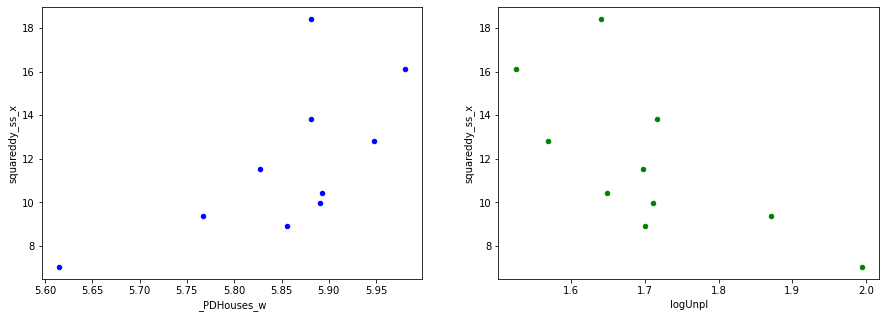

In [136]:
pdfXY = DemandOM.pdfWork.loc[iFirstFactYear:iLastFactYear, [ 'squareddy_ss_x', 'Unmpl_s', 'D', '_PDHouses_w']].dropna()

f1, ax1 = plt.subplots(1, 2, sharey=False, figsize=(15,5))

pdfXY.plot.scatter('_PDHouses_w', 'squareddy_ss_x', ax=ax1[0], color='b')
pdfXY['logUnpl']=np.log(pdfXY['Unmpl_s'])
pdfXY.plot.scatter('logUnpl', 'squareddy_ss_x', ax=ax1[1], color='g');
# pdfXY.plot.scatter('logUnpl', '_PDHouses_w', ax=ax1[0], color='g'); # !!!!!!!!!!!!

<div class="alert alert-danger">
<b>Проверка предикторов на зависимость</b>
</div>

[[ 1.         -0.96529336]
 [-0.96529336  1.        ]]


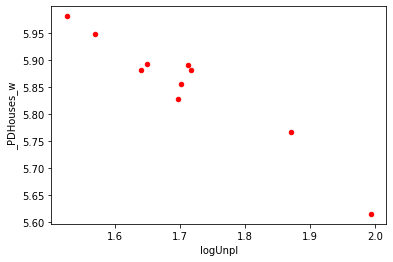

In [137]:
pdfXY.plot.scatter('logUnpl', '_PDHouses_w', color='r'); # !!!!!!!!!!!!
print(np.corrcoef(pdfXY['logUnpl'], y=pdfXY['_PDHouses_w']))

In [138]:
resSSSX = smf.ols(formula='squareddy_ss_x ~_PDHouses_w + np.log(Unmpl_s) + D - 1', missing='drop', data=pdfXY).fit()
print(resSSSX.summary())

                                 OLS Regression Results                                
Dep. Variable:         squareddy_ss_x   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              158.3
Date:                Mon, 01 Mar 2021   Prob (F-statistic):                    8.55e-07
Time:                        13:23:13   Log-Likelihood:                         -18.130
No. Observations:                  10   AIC:                                      42.26
Df Residuals:                       7   BIC:                                      43.17
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

<h1 style="color:maroon">Модель 2. Площадь готового жилья, приобретенного за счет собственных средств</h1>

**Предикторы:**
  - \_demand\_hh	- потенциальный спрос на жилье, скорректированный на соотношение цен
  - \_pct\_DispInc\_rI	- Темп прироста реальных располагаемых доходов населения
  - Ln(Unmpl\_s)	Уровень безработицы
  - D2	дамми-переменные на 2017-2019 гг.
  
### 2.1 Расчет  Потенциального спрос на жилье, скорректированного на соотношение цен спроса (\_demand\_hh)

Для расчета Потенциального спроса ((\_demand\_hh) необходимо расчитать следующие переменные:
  - \_demand\_hh\_calc - Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий
  - \_p\_self\_improve2	- Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, %
  - \_demand\_hh\_m2 -Потенциальный спрос (количество кв. м)
  - \_p\_middle\_class2 -Доля населения с доходами выше порога
  - \_mid\_level2 Порог 
  - \_inc\_percapita\_superrich - Среднедушевые доходы сверхбогатого населения (**считается в 1.1.1**)
  - \_p\_superrich -Доля доходов сверхбогатого населения (**считается в 1.1.1**)
  - \_spend\_hh2 - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения
  - \_part\_income4h2 - Доля денежных доходов, которые могут потратить на жилье (включая ПМ)
  
  
<hr>

  - p\_middleclass2 - Доля населения с доходами выше порога
  - LivMin - Прожиточный минимум
  - \_val\_m4h - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ)
  - \_sum\_val\_PM4dem\_h\_om - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств

а так же переменных, используемых в расчете переменных выше
  - \_p\_income\_superr - Доля доходов сверхбогатого населения
  - \_mid\_level - Порог
  - \_p\_income4h - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения
  - \_inc\_percapita\_superrich - Среднедушевые доходы сверхбогатого населения


#### 2.1.1 Расчет порога \_mid\_level2 и доли населения с доходами выше порога p\_middleclass2

Расчет доли населения с доходами выше порога делаем аналогично расчету доли сверхбогатого населения 

&emsp;&emsp;&emsp;  $p\_middleclass2=1-{\mathcal{N}(MEPop,\,DispPop^{2}).cdf(log(\_mid\_level2)}) $    
  
&emsp;  где cdf - umulative distribution function **нормального распределения** $\mathcal{N}(MEPop,\,DispPop^{2})   $

$\_mid\_level2 = LivMin + \left({\frac{\frac{\large\frac{54}{12}}{\large HHAv}}{\large 7}}\right) * price1mall\_alt\_x$

In [139]:
DemandOM.pdfWork['_mid_level2']=DemandOM.pdfWork['LivMin'] + (54 / 12 / DemandOM.pdfWork['HHAv'] / 7) * DemandOM.pdfWork['price1mall_alt_x']

DemandOM.pdfWork['p_middleclass2']=1-norm.cdf(np.log(DemandOM.pdfWork['_mid_level2']), loc=DemandOM.pdfWork['MEPop'], scale=DemandOM.pdfWork['DispPop'])

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_mid_level', 'p_middleclass', '_mid_level2', 'p_middleclass2']]

,_mid_level,p_middleclass,_mid_level2,p_middleclass2
date,,,,
2015,22671.890766,0.501378,25246.835258,0.445452
2016,22645.834255,0.507539,24948.411035,0.457018
2017,22964.796293,0.514162,25056.222271,0.468410
2018,23723.936931,0.522176,25692.106282,0.480649
2019,25334.707201,0.519061,27199.874390,0.482004
2020,28292.711227,0.460336,29992.225965,0.430190


#### 2.1.2 Доля денежных доходов, которые могут потратить на жилье (включая ПМ) - \_part\_income4h2	

&emsp;&emsp;&emsp; $ \_part\_income4h2 = 1-\displaystyle{\frac{kolmakov.cdf(\_mid\_level2)}{Inc\_x}}$
   
   где 
   - kolmakov.cdf - сumulative distribution function для распределения доходов населения по уровню среднедушевого среднемесячного денежного дохода в денежном выражении (см. выше) с параметрами $\mu=MEPop$ и $\sigma = DispPop$
   - \_mid\_level2 - порог (**считаем в 2.1.2**)
   - Inc\_x - Среднедушевые денежные доходы населения (в текущих ценах) (из базы данных)

In [140]:
def _calc_part_income4h2(x):
    return 1-common.kolmakov.cdf(x['_mid_level2'], sigma=x['DispPop'], mu=x['MEPop'])/x['Inc_x']

DemandOM.pdfWork['_part_income4h2']=DemandOM.pdfWork[['_mid_level2', 'DispPop', 'MEPop', 'Inc_x']].apply(_calc_part_income4h2, axis=1)

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_part_income4h2', 'DispPop', 'MEPop', '_mid_level2', 'Inc_x']]

,_part_income4h2,DispPop,MEPop,_mid_level2,Inc_x
date,,,,,
2015,0.733159,0.765043,10.031523,25246.835258,30254.400000
2016,0.744891,0.763400,10.042158,24948.411035,30865.000000
2017,0.755051,0.759399,10.068682,25056.222271,31896.500000
2018,0.763244,0.765300,10.116803,25692.106282,33178.100000
2019,0.764398,0.764492,10.176471,27199.874390,35249.300000
2020,0.722230,0.764492,10.174226,29992.225965,35154.629192


#### 2.1.3  Расчет общего объема денежных доходов, которые могут потратить на жилье (включая ПМ) - \_calc\_val\_m4h2,  Суммарного объема ПМ населения, которое может предъявить спрос на жилье за счет собственных средств - \_sum\_val\_PM4dem\_h\_om2, Общего объема денежных доходов, которые могут потратить на жилье (включая ПМ) - \_val\_m4h2 и Доли денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения - \_spend\_hh2
 
$\displaystyle \_calc\_val\_m4h2 = \_p\_income4h2 * \_comm\_income$    

$\_spend\_hh2 = \_part\_income4h2 - \_p\_income\_superr $

$\displaystyle \_val\_m4h2 = \_spend\_hh2 * \_comm\_income$ 

$ \_sum\_val\_PM4dem\_h\_om2 = \displaystyle \frac{12 * LivMin * p\_middleclass2 * Pop\_x}{1000}$

где
  - \_p\_income_superr - Доля доходов сверхбогатого населения (**считаем в 1.1.1**)
  - \_part\_income4h2 - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) (**считаем в 2.1.2**)
  - \_p\_income4h2 - Доля денежных доходов, которые могут потратить на жилье (включая ПМ) за исключением доходов сверхбогатого населения (**считаем в 2.1.2**)
  - \_comm\_income - Общий объем денежных доходов населения (**считаем в 1.1.4**)
  - LivMin - Прожиточный минимум (**считаем в 1.1.2**)
  - p_middleclass2 - Доля населения с доходами выше порог (**считаем в 2.1.1**)

In [141]:
DemandOM.pdfWork['_calc_val_m4h2'] = DemandOM.pdfWork['_comm_income'] * DemandOM.pdfWork['_part_income4h2']
DemandOM.pdfWork['_spend_hh2'] = DemandOM.pdfWork['_part_income4h2'] - DemandOM.pdfWork['_p_income_superr']
DemandOM.pdfWork['_val_m4h2'] = DemandOM.pdfWork['_comm_income'] * DemandOM.pdfWork['_spend_hh2']
DemandOM.pdfWork['_sum_val_PM4dem_h_om2'] = 12 * DemandOM.pdfWork['LivMin'] * DemandOM.pdfWork['p_middleclass2'] * DemandOM.pdfWork['Pop_x'] / 1e3


DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_sum_val_PM4dem_h_om2', '_val_m4h2', '_calc_val_m4h2', '_spend_hh2', '_comm_income', 'LivMin' ,'Pop_x']]

,_sum_val_PM4dem_h_om2,_val_m4h2,_calc_val_m4h2,_spend_hh2,_comm_income,LivMin,Pop_x
date,,,,,,,
2015,7592.028767,34046.286544,38969.678852,0.640532,53153.107874,9701.000000,146.405999
2016,7905.599477,34930.048760,40466.421967,0.642979,54325.316496,9828.000000,146.674541
2017,8326.524246,36276.103211,42437.702248,0.645424,56205.103722,10088.000000,146.842401
2018,8711.933550,38842.820702,44618.243996,0.664449,58458.714005,10287.000000,146.830575
2019,9244.457011,41245.272387,47453.992005,0.664387,62080.216242,10890.000000,146.764655
2020,8519.299686,38531.411875,44695.905038,0.622620,61885.932914,11249.529243,146.699345


#### 2.1.4 Расчет Общего объема денежных доходов, которые могут потратить на жилье - \_val\_incom2house2 <br>и Потенциального спроса (количество кв. м) -\_demand\_hh\_m2

<br>
<center>$ \_demand\_hh\_m2 = \dfrac{\_val\_incom2house2 * 1000}{price1mall\_alt\_x}$</center>

где 
  - \_val\_incom2house2 - Общий объем денежных доходов, которые могут потратить на жилье
  
  $ \_val\_incom2house2 = \_val\_m4h2 - \_sum\_val\_PM4dem\_h\_om2 $   
  
  
  - price1mddy\_alt\_x - Средняя цена 1 кв. м на рынке готового жилья (**из другого блока**)
  
  
  
где
  - \_val\_m4h2 - Общий объем денежных доходов, которые могут потратить на жилье (включая ПМ) (**считаем в 2.1.3**)
  - \_sum\_val\_PM4dem\_h\_om2 - Суммарный объем ПМ населения, которое может предъявить спрос на жилье за счет собственных средств (**считаем в 2.1.3**)

In [142]:
DemandOM.pdfWork['_val_income2house2'] = DemandOM.pdfWork['_val_m4h2'] - DemandOM.pdfWork['_sum_val_PM4dem_h_om2']
DemandOM.pdfWork['_demand_hh_m2'] = DemandOM.pdfWork['_val_income2house2'] * 1e3 / DemandOM.pdfWork['price1mall_alt_x']

DemandOM.pdfWork.loc[iFirstForecastYear-5:iFirstForecastYear, ['_demand_hh_m2', '_val_income2house2', '_val_m4h2', '_sum_val_PM4dem_h_om2']]

,_demand_hh_m2,_val_income2house2,_val_m4h2,_sum_val_PM4dem_h_om2
date,,,,
2015,458.373429,26454.257777,34046.286544,7592.028767
2016,481.427805,27024.449284,34930.048760,7905.599477
2017,502.971018,27949.578965,36276.103211,8326.524246
2018,526.847756,30130.887152,38842.820702,8711.933550
2019,528.504078,32000.815376,41245.272387,9244.457011
2020,431.322782,30012.112189,38531.411875,8519.299686


#### 2.1.5 Доля семей, фактически улучшивших жилищные условия за скользящие 7лет за счет собственных средств в отношении к тем, кому доступно улучшение жилищных условий за счет собственных средств, % - \_p\_self\_improve2

$ \_p\_self\_improve2 = \large\frac{UZUss\_s}{\_p\_middleclass2} $

In [143]:
DemandOM.pdfWork['_p_self_improve2'] = DemandOM.pdfWork['UZUss_s'] / DemandOM.pdfWork['p_middleclass2']
DemandOM.pdfWork['_p_self_improve2'] = DemandOM.pdfWork['_p_self_improve2'].bfill()

### 2.2 Расчет потенциального спроса населения на готовое жилье за счет собственных средств c поправочным коэфф-том, учитывающим насыщение потребности в улучшении жилищных условий - \_demand\_hh\_calc и Потенциального спроса на жилье (без лага с весом 0.5, с лагом 1 год с весом 0.5), скорректированный на соотношение цен - \_demand\_hh (Регрессор модели)
<br>

<center>$ \_demand\_hh\_calc = \_demand\_hh\_m2+p\_superrich \cdot \_superrich\_buy \cdot Pop\_x \cdot (1-\_p\_self\_improve2_{y-1})$</center>
<br>   
   
<center>$ \_demand\_hh = \ln \left( \dfrac{\_demand\_hh\_calc_{y-1} \cdot 0.5 + \_demand\_hh\_calc_y \cdot 0.5}{(1 + p\_ProbDef) \dfrac{price1mddy\_alt\_x}{price1mall\_alt\_x}} \right)$</center>

### 2.3 ...и добавляем дамми2

In [144]:
DemandOM.pdfWork['_demand_hh_calc'] = (DemandOM.pdfWork['_demand_hh_m2'] + DemandOM.pdfWork['p_superrich'] * DemandOM.pdfWork['_superrich_buy'] 
                                  * DemandOM.pdfWork['Pop_x']) * (1 - DemandOM.pdfWork['_p_self_improve2'].shift(1))

DemandOM.pdfWork['_demand_hh']=(np.log( 
    (DemandOM.pdfWork['_demand_hh_calc'].shift(1)*0.5 + DemandOM.pdfWork['_demand_hh_calc']*0.5) 
    / ((1+DemandOM.pdfWork['p_ProbDef']) * DemandOM.pdfWork['price1mddy_alt_x'] / DemandOM.pdfWork['price1mall_alt_x']) )
    )

DemandOM.pdfWork['D2']=0
DemandOM.pdfWork.loc[2017:2019, 'D2']=1
DemandOM.pdfWork[['_demand_hh', 'D2']].dropna()

,_demand_hh,D2
date,,
2009,5.034321,0
2010,5.295609,0
2011,5.474815,0
2012,5.516242,0
2013,5.509054,0
2014,5.518032,0
2015,5.522490,0
2016,5.560559,0
2017,5.598572,1


### 2.4 Оценка модели 2 - Площадь готового жилья, приобретенного за счет собственных средств

**Регрессоры:**
  - Потенциальный спрос на жилье, скорректированный на соотношение цен  - \_demand\_hh (**расчетный**)
  - Уровень безработицы - Ln(Unmpl\_s) (**из базы данных**)
  - Темп прироста реальных располагаемых доходов населения - Ln(\_pct\_DispInc\_I) (**из базы данных**)
  - Дамми-переменная на 2017 - 2019 гг. 
     <br><br>   
<center>  $\large squarekp\_ss\_x \sim \_demand\_hh + Ln(Unmpl\_s) + Ln(DispInc\_I) +  D2_{(2017-2019)} - 1 $  </center>

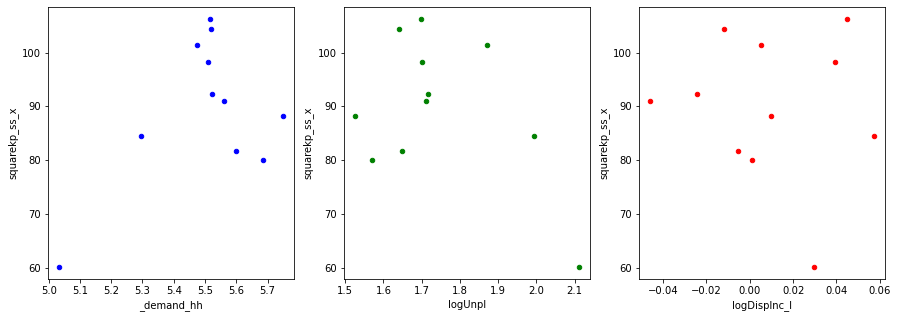

In [145]:
pdfXY2 = DemandOM.pdfWork.loc[iFirstFactYear:iLastFactYear, ['squarekp_ss_x', '_demand_hh', 'DispInc_I', 'Unmpl_s', 'D2']].dropna()

f2, ax2 = plt.subplots(1, 3, sharey=False, figsize=(15,5))


pdfXY2['logUnpl']=np.log(pdfXY2['Unmpl_s'])
pdfXY2['logDispInc_I']=np.log(pdfXY2['DispInc_I'])
pdfXY2.plot.scatter('_demand_hh',   'squarekp_ss_x', ax=ax2[0], color='b')
# pdfXY2.plot.scatter('_demand_hh',   'logUnpl', ax=ax2[0], color='b') # !!!!!!!!!!!!
pdfXY2.plot.scatter('logUnpl',      'squarekp_ss_x', ax=ax2[1], color='g')
pdfXY2.plot.scatter('logDispInc_I', 'squarekp_ss_x', ax=ax2[2], color='r');

<div class="alert alert-danger">
<b>Проверка предикторов на зависимость</b>
</div>

              _demand_hh   logUnpl  logDispInc_I
_demand_hh      1.000000 -0.954073     -0.424405
logUnpl        -0.954073  1.000000      0.421656
logDispInc_I   -0.424405  0.421656      1.000000


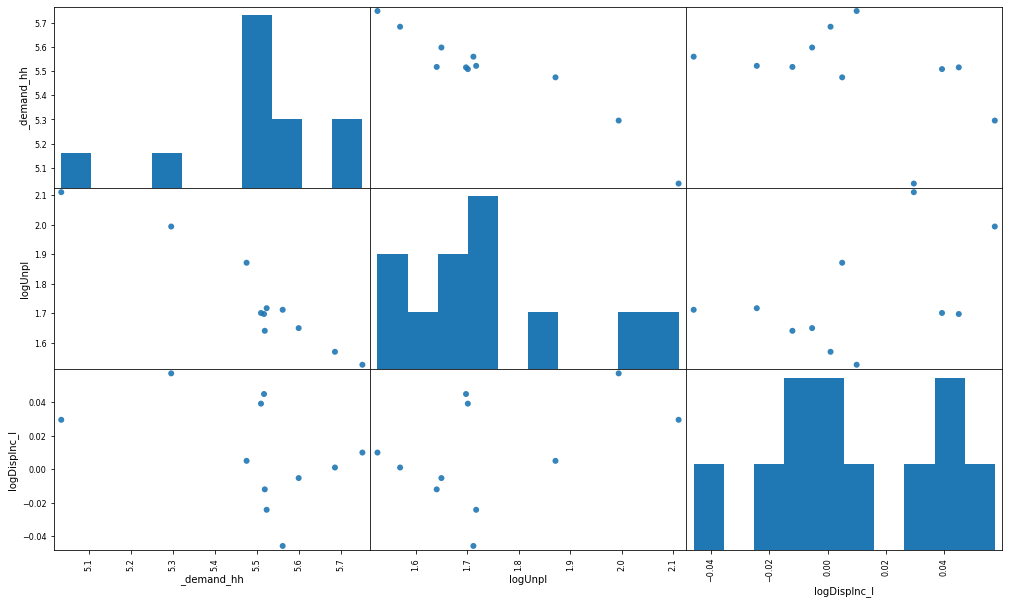

In [146]:
pd.plotting.scatter_matrix(pdfXY2[['_demand_hh',   'logUnpl', 'logDispInc_I']], figsize=(17, 10), marker='o', alpha=0.9);
print(pdfXY2[['_demand_hh',   'logUnpl', 'logDispInc_I']].corr())

In [147]:
# pdfWork[['squarekp_ss_x', '_demand_hh', 'DispInc_I', 'Unmpl_s', 'D2']].dropna()
# pdfXY2 = DemandOM.pdfWork.loc[iFirstFactYear:iLastFactYear, ['squarekp_ss_x', '_demand_hh', 'DispInc_I', 'Unmpl_s', 'D2']].dropna()

resKPSSX = smf.ols(formula='squarekp_ss_x ~_demand_hh + np.log(Unmpl_s) + np.log(DispInc_I) + D2 - 1', missing='drop', data=pdfXY2).fit()
print(resKPSSX.summary())

                                 OLS Regression Results                                
Dep. Variable:          squarekp_ss_x   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              564.8
Date:                Mon, 01 Mar 2021   Prob (F-statistic):                    7.35e-09
Time:                        13:23:18   Log-Likelihood:                         -33.407
No. Observations:                  11   AIC:                                      74.81
Df Residuals:                       7   BIC:                                      76.41
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

<h1 style="color:darkgreen">Модель 3. Счет семей УЖУ</h1> 

In [83]:
DemandOM.pdfWork['oldsdelkiddy_x']=DemandOM.pdfWork['oldpravaddy_x']/1.5
# Задание горизонта оценивания модели и лагов
iStart=2010
iEnd=2018

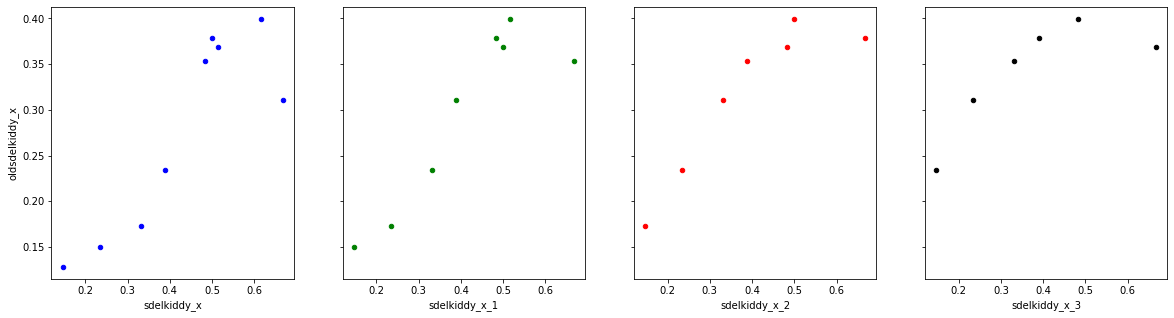

In [87]:
pdfXY3 = DemandOM.pdfWork.loc[iStart:iEnd, ['oldsdelkiddy_x', 'sdelkiddy_x', 'DispInc_I', 'Unmpl_s', 'D2']].dropna()

f3, ax3 = plt.subplots(1, 4, sharey=True, figsize=(20,5))


pdfXY3['sdelkiddy_x_1']=pdfXY3['sdelkiddy_x'].shift(1)
pdfXY3['sdelkiddy_x_2']=pdfXY3['sdelkiddy_x'].shift(2)
pdfXY3['sdelkiddy_x_3']=pdfXY3['sdelkiddy_x'].shift(3)
pdfXY3.plot.scatter('sdelkiddy_x',        'oldsdelkiddy_x', ax=ax3[0], color='b')
pdfXY3.plot.scatter('sdelkiddy_x_1',      'oldsdelkiddy_x', ax=ax3[1], color='g')
pdfXY3.plot.scatter('sdelkiddy_x_2',      'oldsdelkiddy_x', ax=ax3[2], color='r');
pdfXY3.plot.scatter('sdelkiddy_x_3',      'oldsdelkiddy_x', ax=ax3[3], color='k');

In [34]:
mod = smf.ols(formula='''oldsdelkiddy_x ~ sdelkiddy_x + sdelkiddy_x.shift(1) + sdelkiddy_x.shift(2) 
              + sdelkiddy_x.shift(3) - 1''', 
              data=DemandOM.pdfWork.loc[iStart:iEnd])
resUZU = mod.fit()
print(resUZU.summary())

                                 OLS Regression Results                                
Dep. Variable:         oldsdelkiddy_x   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              692.1
Date:                Mon, 15 Feb 2021   Prob (F-statistic):                     0.00144
Time:                        14:30:12   Log-Likelihood:                          19.573
No. Observations:                   6   AIC:                                     -31.15
Df Residuals:                       2   BIC:                                     -31.98
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [36]:
DemandOM.pdfWork['oldsdelkiddy_xM']=resUZU.predict(DemandOM.pdfWork)
DemandOM.pdfWork.loc[iFirstForecastYear:iLastForecastYear+1,'oldsdelkiddy_x']=DemandOM.pdfWork.loc[iFirstForecastYear:iLastForecastYear+1,'oldsdelkiddy_xM']

for i in range(iFirstForecastYear-1, iLastForecastYear+1):
    DemandOM.pdfWork.loc[i,'longarenda']=(DemandOM.pdfWork.loc[i-1,'longarenda'] * 
                                           ((DemandOM.pdfWork.loc[i,'VvodyMKDunits'] * 
                                             DemandOM.pdfWork.loc[i,'VvodyMKD_inst'] / 
                                             DemandOM.pdfWork.loc[i,'VvodyMKD']) / 
                                            (DemandOM.pdfWork.loc[i-1,'VvodyMKDunits'] * 
                                             DemandOM.pdfWork.loc[i-1,'VvodyMKD_inst'] / DemandOM.pdfWork.loc[i-1,'VvodyMKD'])))
    DemandOM.pdfWork.loc[i,'izavarijnogo']=(DemandOM.pdfWork.loc[i-1,'izavarijnogo'] * 
                                             ((DemandOM.pdfWork.loc[i,'Badzhilfond_x'] / 
                                               DemandOM.pdfWork.loc[i,'AvSqVtor']) / 
                                              (DemandOM.pdfWork.loc[i-1,'Badzhilfond_x'] / DemandOM.pdfWork.loc[i-1,'AvSqVtor'])))
    DemandOM.pdfWork.loc[i,'kapremont']=(DemandOM.pdfWork.loc[i-1,'kapremont'] * 
                                          (DemandOM.pdfWork.loc[i,'oldsdelkiddy_x'] / DemandOM.pdfWork.loc[i-1,'oldsdelkiddy_x'])**0.95)
    DemandOM.pdfWork.loc[i,'partinZSK']=(DemandOM.pdfWork.loc[i-1,'partinZSK'] * 
                                          (DemandOM.pdfWork.loc[i,'oldsdelkiddy_x']/DemandOM.pdfWork.loc[i-1,'oldsdelkiddy_x'])**0.95)

DemandOM.pdfWork['socnaim']=DemandOM.pdfWork['VvodyMKDunits']*DemandOM.pdfWork['VvodyMKD_gov']/DemandOM.pdfWork['VvodyMKD']
DemandOM.pdfWork['sdelki_other']=DemandOM.pdfWork[['VvodyIZDunits','socnaim','longarenda','izavarijnogo','kapremont','partinZSK']].sum(axis=1)
DemandOM.pdfWork['UZU_x']=DemandOM.pdfWork[['sdelkikp_x','oldsdelkiddy_x','sdelki_other']].sum(axis=1)
DemandOM.pdfWork[['VvodyIZDunits','socnaim','longarenda','izavarijnogo','kapremont','partinZSK']]

,VvodyIZDunits,socnaim,longarenda,izavarijnogo,kapremont,partinZSK
date,,,,,,
2007,0.190000,NaN,NaN,0.059742,NaN,NaN
2008,0.200000,0.052915,NaN,0.060387,NaN,NaN
2009,0.210000,0.060705,NaN,0.067637,NaN,NaN
2010,0.192000,0.066150,NaN,0.023000,NaN,NaN
2011,0.201000,0.074108,NaN,0.026000,NaN,NaN
2012,0.211000,0.050568,NaN,0.028000,NaN,NaN
2013,0.228000,0.053201,NaN,0.025000,NaN,NaN
2014,0.268000,0.050637,NaN,0.071000,NaN,NaN
2015,0.272000,0.053376,NaN,0.074000,NaN,NaN


# 3. Расчет окончательного результата

На **прогнозном отрезке** UZUss_x расчитывается по формуле:

$ UZUss\_x_y = \displaystyle\sum\limits_{i=y-7}^y{\_cnt\_deal\_om_i}$

$ \_cnt\_deal\_om = sdelkidd\_ss\_x + sdelkikp\_ss\_x $

$ sdelkidd\_ss\_x = \displaystyle\frac{squareddy\_ss\_x}{AvSqDdy}\quad; \qquad sdelkikp\_ss\_x = \displaystyle\frac{squarekp\_ss\_x}{AvSqVtor}$

где 
  - \_cnt\_deal\_om - Количество сделок по покупке жилья за счет собственных средств на первичном и вторичном рынках
  - sdelkidd\_ss\_x - Количество сделок с ДДУ/Эскроу
  - sdelkikp\_ss\_x - Количество сделок по договорам купли-продажи
  - AvSqDdy - Средняя площадь квартиры, приобретаемой по ДДУ/Эскроу (на этапе строительства), кв. м (**из СВОДА**)
  - AvSqVtor - Средняя площадь квартиры, приобретаемой на вторичном рынке, кв. м (**из СВОДА**)
  - squareddy\_ss\_x - Площадь строящегося жилья, приобретенного за счет собственных средств (**результат Модели 1 этого блокнота**)
  - squarekp\_ss\_x - Площадь готового жилья, приобретенного за счет собственных средств (**результат Модели 2 этого блокнота**)

Дальше расчитываем 
  - $ \_p\_self\_improve = \large\frac{UZUss\_s}{p\_middleclass} \quad $, \_Calc\_PD\_FH\_OM\_Corr и \_PDHouses\_w - предиктор Модели 1
  - $ \_p\_self\_improve2 = \large\frac{UZUss\_s}{p\_middleclass2} \quad $, \_demand\_hh\_calc и \_demand\_hh\_calc - предиктор Модели 2

Однако переменные \_p\_self\_improve и \_p\_self\_improve2 входят в формулу расчета предикторов с лагом 1 год - то есть **для расчета текущего значения предикторов используются результаты моделирования для предидущего года**


In [ ]:
pdfWork1=DemandOM.pdfWork.copy()

for i in range(iFirstForecastYear, iLastForecastYear+1):
    _pdf=pdfWork1.loc[i, :]

    _pdf['squareddy_ss_x'] = (resSSSX.params['_PDHouses_w'] * _pdf['_PDHouses_w'] 
                      + resSSSX.params['np.log(Unmpl_s)'] * np.log(_pdf['Unmpl_s']) 
                      + resSSSX.params['D'] * _pdf['D'])
    

    _pdf['squarekp_ss_x'] = (resKPSSX.params['_demand_hh'] * _pdf['_demand_hh'] 
                      + resKPSSX.params['np.log(Unmpl_s)'] * np.log(_pdf['Unmpl_s'])       
                      + resKPSSX.params['np.log(DispInc_I)'] * np.log(_pdf['DispInc_I']) 
                      + resKPSSX.params['D2'] * _pdf['D2'])


    _pdf['sdelkiddy_ss_x']=_pdf['squareddy_ss_x']/_pdf['AvSqDdy']
    _pdf['sdelkikp_ss_x']=_pdf['squarekp_ss_x']/_pdf['AvSqVtor']

    _pdf['_cnt_deal_om']=_pdf[['sdelkiddy_ss_x', 'sdelkikp_ss_x']].sum()    
    _pdf['UZUss_x']=pdfWork1.loc[i-7:i, '_cnt_deal_om'].sum()
    _pdf['UZUss_s'] = _pdf['UZUss_x'] / _pdf['_cnt_hh']
    _pdf['_p_self_improve'] = _pdf['UZUss_s'] / _pdf['p_middleclass']
    _pdf['_p_self_improve2'] = _pdf['UZUss_s'] / _pdf['p_middleclass2']

    pdfWork1.loc[i, :]=_pdf
    # дальше идет расчет предикторов для моделей на следующий прогнозный год
    _pdf=pdfWork1.loc[i+1, :]
    
    _pdf['_Calc_PD_FH_OM_Corr'] = (_pdf['_PD'] + _pdf['p_superrich'] * _pdf['_superrich_buy'] 
                                  * _pdf['Pop_x']) * (1 - pdfWork1.loc[i-1, '_p_self_improve'])   ### вот тут берем предидущий год
    _pdf['_PDHouses_w']=(np.log( 
        (pdfWork1.loc[i-1, '_Calc_PD_FH_OM_Corr']*0.5 + _pdf['_Calc_PD_FH_OM_Corr']*0.5) 
        / ((1+_pdf['p_ProbDef']) * _pdf['price1mddy_alt_x'] / _pdf['price1mall_alt_x']) )
        )
    
    _pdf['_demand_hh_calc'] = (_pdf['_demand_hh_m2'] + _pdf['p_superrich'] * _pdf['_superrich_buy'] 
                                  * _pdf['Pop_x']) * (1 - pdfWork1.loc[i-1, '_p_self_improve2'])

    _pdf['_demand_hh']=(np.log( 
    (pdfWork1.loc[i-1, '_demand_hh_calc']*0.5 + _pdf['_demand_hh_calc']*0.5) 
    / ((1+_pdf['p_ProbDef']) * _pdf['price1mddy_alt_x'] / _pdf['price1mall_alt_x']) )
    )

    pdfWork1.loc[i+1, :]=_pdf


In [ ]:
pdfWork1[['squareddy_ss_x', 'squarekp_ss_x', '_p_self_improve', '_p_self_improve2']]